### Introduction

1. **Extractive Summary:** The network calculates the most important sentences from the article and gets them together to provide the most meaningful information from the article.
2. **Abstractive Summary**: The network creates new sentences to encapsulate maximum gist of the article and generates that as output. The sentences in the summary may or may not be contained in the article. 

**Data**:
- We are using the News Summary dataset available at [Kaggle](https://www.kaggle.com/sunnysai12345/news-summary)
    
**In this notebook**:
- Introduction
- Data Exploration
- Data Cleaning
- Text/Data Preprocessing Steps
- Word Embeddings
- POS Tagging
- Named Entity Recognition
- Sentence Embeddings

### Import necessary libraries

In [13]:
import nltk
import seaborn as sns 
import matplotlib.pyplot as plt
import regex as re
import numpy as np
import pandas as pd
import warnings
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet,stopwords
import spacy
from spacy import displacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models.word2vec import Word2Vec
from gensim.models import FastText
from sentence_transformers import SentenceTransformer

In [ ]:
# !pip install sentence_transformers

### Load the data 

In [14]:
path_, filename_, category_, article_or_summary_ = [],[],[],[]
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        path_.append(os.path.join(dirname, filename))
        filename_.append(filename)
        category_.append(dirname.split("/")[-1])
        article_or_summary_.append(dirname.split("/")[-2])

In [15]:
bbc = pd.DataFrame({"path":path_, "filename":filename_, "category":category_, "article_or_summary":article_or_summary_}, columns=["path", "filename", "category", "article_or_summary"])
bbc.head()

,path,filename,category,article_or_summary
0,/kaggle/input/bbc-news-summary/BBC News Summar...,361.txt,politics,Summaries
1,/kaggle/input/bbc-news-summary/BBC News Summar...,245.txt,politics,Summaries
2,/kaggle/input/bbc-news-summary/BBC News Summar...,141.txt,politics,Summaries
3,/kaggle/input/bbc-news-summary/BBC News Summar...,372.txt,politics,Summaries
4,/kaggle/input/bbc-news-summary/BBC News Summar...,333.txt,politics,Summaries


### Explore the dataset and perform some basic pre-processing

In [16]:
bbc.info() # no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8903 entries, 0 to 8902
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   path                8903 non-null   object
 1   filename            8903 non-null   object
 2   category            8903 non-null   object
 3   article_or_summary  8903 non-null   object
dtypes: object(4)
memory usage: 278.3+ KB


In [17]:
bbc['path'][0],bbc['path'][1],bbc['path'][2] # not in a particular order

('/kaggle/input/bbc-news-summary/BBC News Summary/Summaries/politics/361.txt',
 '/kaggle/input/bbc-news-summary/BBC News Summary/Summaries/politics/245.txt',
 '/kaggle/input/bbc-news-summary/BBC News Summary/Summaries/politics/141.txt')

In [18]:
bbc['filename'][0]

'361.txt'

In [19]:
bbc['category'].unique()

array(['politics', 'sport', 'tech', 'entertainment', 'business',
       'news-summary', 'bbc-news'], dtype=object)

In [20]:
bbc['article_or_summary'].unique()

array(['Summaries', 'News Articles', 'input'], dtype=object)

In [21]:
bbc.index[bbc['article_or_summary'] == 'input']

Index([8900, 8901, 8902], dtype='int64')

In [22]:
bbc['path'][8900], bbc['category'][8900], bbc['article_or_summary'][8900]

('/kaggle/input/news-summary/news_summary_more.csv', 'news-summary', 'input')

In [23]:
bbc.drop([8900, 8901, 8902],inplace=True)

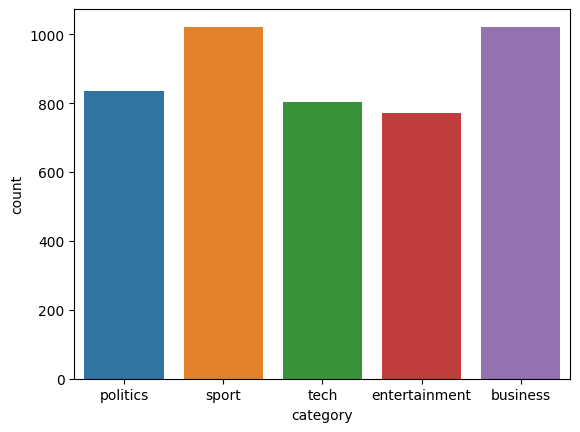

In [24]:
# Visualize the distribution of news articles across different categories 
sns.countplot(x='category', data=bbc[bbc['article_or_summary'] == "News Articles"]);

Text(0.5, 1.0, 'Percentage of News Articles by Category')

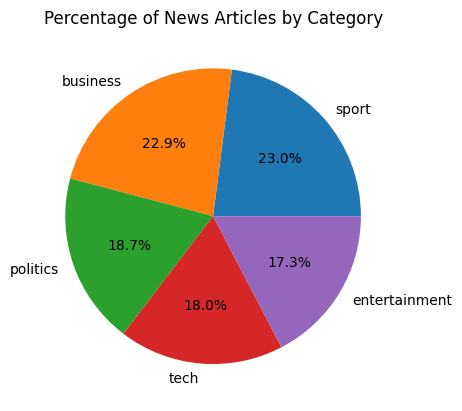

In [25]:
temp = bbc[bbc['article_or_summary'] == "News Articles"]
category_percentages = temp['category'].value_counts(normalize=True) * 100

plt.pie(category_percentages, labels=category_percentages.index, autopct='%1.1f%%')
plt.title('Percentage of News Articles by Category')

In [26]:
summaries_df = bbc[bbc['article_or_summary'] == 'Summaries']
news_articles_df = bbc[bbc['article_or_summary'] == 'News Articles']

In [27]:
summaries_df.head(2)

,path,filename,category,article_or_summary
0,/kaggle/input/bbc-news-summary/BBC News Summar...,361.txt,politics,Summaries
1,/kaggle/input/bbc-news-summary/BBC News Summar...,245.txt,politics,Summaries


In [28]:
news_articles_df.head(2)

,path,filename,category,article_or_summary
2225,/kaggle/input/bbc-news-summary/BBC News Summar...,361.txt,politics,News Articles
2226,/kaggle/input/bbc-news-summary/BBC News Summar...,245.txt,politics,News Articles


In [29]:
summaries_df.shape, news_articles_df.shape

((4450, 4), (4450, 4))

In [30]:
# drop article_or_summary
news_articles_df.drop(['article_or_summary'],axis=1,inplace=True)
summaries_df.drop(['article_or_summary'],axis=1,inplace=True)

/tmp/ipykernel_33/1370009517.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_articles_df.drop(['article_or_summary'],axis=1,inplace=True)
/tmp/ipykernel_33/1370009517.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summaries_df.drop(['article_or_summary'],axis=1,inplace=True)


In [31]:
summaries_df.isnull().sum(), news_articles_df.isnull().sum() # no null values

(path        0
 filename    0
 category    0
 dtype: int64,
 path        0
 filename    0
 category    0
 dtype: int64)

In [32]:
def extract_text_from_files(data_df):
    text_list = []
    for index, row in data_df.iterrows():
        file_path = row['path']
        try:
            with open(file_path, "r", encoding="utf-8") as f:
                text = f.read()
            text_list.append(text)
        except UnicodeDecodeError:
            with open(file_path, "r", encoding="latin1") as f:
                text = f.read()
            text_list.append(text)
    return text_list

In [33]:
# Extract articles
articles = extract_text_from_files(news_articles_df)

# Extract summaries
summaries = extract_text_from_files(summaries_df)

In [34]:
len(articles)

4450

In [35]:
len(summaries)

4450

In [36]:
data = pd.DataFrame({'text': articles,'summary':summaries})
data.head()

,text,summary
0,Budget to set scene for election\n\nGordon Bro...,- Increase in the stamp duty threshold from £6...
1,Army chiefs in regiments decision\n\nMilitary ...,"""They are very much not for the good and will ..."
2,Howard denies split over ID cards\n\nMichael H...,Michael Howard has denied his shadow cabinet w...
3,Observers to monitor UK election\n\nMinisters ...,The report said individual registration should...
4,Kilroy names election seat target\n\nEx-chat s...,"UKIP's leader, Roger Knapman, has said he is g..."


In [37]:
data['text'][10], data['summary'][10]

("Hatfield executives go on trial\n\nEngineering firm Balfour Beatty and five railway managers are to go on trial for manslaughter over the Hatfield rail crash in 2000.\n\nFour people died when a section of rail broke and a high speed train derailed. Balfour Beatty's railway maintenance arm was in charge of the upkeep of the line at Hatfield, Hertfordshire. Balfour Beatty managers Anthony Walker and Nicholas Jeffries, and Railtrack managers Alistair Cook, Sean Fugill and Keith Lea all face individual charges. All five men, along with four others, are also accused of breaches of health and safety laws. Balfour Beatty Rail Maintenance faces a corporate manslaughter charge. It is expected the trial could last as long as a year. The accident, on 17 October 2000, happened when the London to Leeds express came off the tracks at 115 mph, when it was derailed by a cracked section of rail. The accident on the East Coast Main Line sparked major disruption. The overall responsibility for the line

### Cleaning the data 

1. **Lowercasing**: Convert all text to lowercase to ensure consistency in representation.

2. **Handling Contractions**: Expand contractions into their full forms, e.g., "can't" to "cannot".

3. **Tokenization**: Split text into individual words or tokens.

4. **Stopword Removal**: Remove common words that do not carry significant meaning, such as "the", "is", "and".

5. **Noise Removal**: Eliminate irrelevant characters and symbols.

6. **Punctuation Removal**: Remove punctuation marks from the text.

7. **Stemming**: Reduce words to their root form by removing suffixes, e.g., "running" to "run".

8. **Lemmatization**: Similar to stemming, but reduces words to their base or dictionary form, e.g., "running" to "run".

`Lowercasing`

In [38]:
def lowercase(data,column_name):
    data[column_name] = data[column_name].str.lower()
    
print('Before Lowercasing : ', data['text'][0])
lowercase(data, 'text')
print('After Lowercasing : ', data['text'][0])

Before Lowercasing :  Budget to set scene for election

Gordon Brown will seek to put the economy at the centre of Labour's bid for a third term in power when he delivers his ninth Budget at 1230 GMT. He is expected to stress the importance of continued economic stability, with low unemployment and interest rates. The chancellor is expected to freeze petrol duty and raise the stamp duty threshold from £60,000. But the Conservatives and Lib Dems insist voters face higher taxes and more means-testing under Labour.

Treasury officials have said there will not be a pre-election giveaway, but Mr Brown is thought to have about £2bn to spare.

- Increase in the stamp duty threshold from £60,000 
 - A freeze on petrol duty 
 - An extension of tax credit scheme for poorer families 
 - Possible help for pensioners The stamp duty threshold rise is intended to help first time buyers - a likely theme of all three of the main parties' general election manifestos. Ten years ago, buyers had a much gre

`URL Removal`

In [39]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

data['text'] = data['text'].apply(remove_urls)

`Unwanted Characters Removal and Punctuation Removal`

In [40]:
# function to find a list of unwanted symbols
def find_unwanted_symbols(text_list):
    unwanted_symbols = []
    for text in text_list:
        for char in text:
            if not char.isalnum() and char not in [' ','.']: # removing '.' in the next step
                unwanted_symbols.append(char)
    return list(set(unwanted_symbols))

In [41]:
flat_list = [item for sublist in data['text'].tolist() for item in sublist]

# find unwanted symbols in sources
unwanted_symbols = find_unwanted_symbols(flat_list)
print(unwanted_symbols)

['(', '-', '+', ')', '@', '&', '#', '"', '=', '$', '`', '!', '£', '%', "'", ':', ';', '?', '[', '/', ']', '*', ',', '\n']


In [42]:
def remove_unwanted_symbols(text_list, unwanted_symbols):
    return [''.join([char for char in text if char not in unwanted_symbols]) for text in text_list]

print('Before removing unwanted symbols : ', data['text'][0])  
data['text'] = remove_unwanted_symbols(data['text'], unwanted_symbols)
print('After removing unwanted symbols : ', data['text'][0])

Before removing unwanted symbols :  budget to set scene for election

gordon brown will seek to put the economy at the centre of labour's bid for a third term in power when he delivers his ninth budget at 1230 gmt. he is expected to stress the importance of continued economic stability, with low unemployment and interest rates. the chancellor is expected to freeze petrol duty and raise the stamp duty threshold from £60,000. but the conservatives and lib dems insist voters face higher taxes and more means-testing under labour.

treasury officials have said there will not be a pre-election giveaway, but mr brown is thought to have about £2bn to spare.

- increase in the stamp duty threshold from £60,000 
 - a freeze on petrol duty 
 - an extension of tax credit scheme for poorer families 
 - possible help for pensioners the stamp duty threshold rise is intended to help first time buyers - a likely theme of all three of the main parties' general election manifestos. ten years ago, buyers 

`Remove '.'`

In [43]:
data['punct_removed'] = data['text'].str.replace('.', '')

In [44]:
data['punct_removed'][0]

'budget to set scene for electiongordon brown will seek to put the economy at the centre of labours bid for a third term in power when he delivers his ninth budget at 1230 gmt he is expected to stress the importance of continued economic stability with low unemployment and interest rates the chancellor is expected to freeze petrol duty and raise the stamp duty threshold from 60000 but the conservatives and lib dems insist voters face higher taxes and more meanstesting under labourtreasury officials have said there will not be a preelection giveaway but mr brown is thought to have about 2bn to spare increase in the stamp duty threshold from 60000   a freeze on petrol duty   an extension of tax credit scheme for poorer families   possible help for pensioners the stamp duty threshold rise is intended to help first time buyers  a likely theme of all three of the main parties general election manifestos ten years ago buyers had a much greater chance of avoiding stamp duty with close to half

`Tokenization`

In [45]:
# nltk.download('punkt')

In [46]:
data['tokenized_text'] = data['punct_removed'].apply(word_tokenize)

print(data['tokenized_text'][0])

['budget', 'to', 'set', 'scene', 'for', 'electiongordon', 'brown', 'will', 'seek', 'to', 'put', 'the', 'economy', 'at', 'the', 'centre', 'of', 'labours', 'bid', 'for', 'a', 'third', 'term', 'in', 'power', 'when', 'he', 'delivers', 'his', 'ninth', 'budget', 'at', '1230', 'gmt', 'he', 'is', 'expected', 'to', 'stress', 'the', 'importance', 'of', 'continued', 'economic', 'stability', 'with', 'low', 'unemployment', 'and', 'interest', 'rates', 'the', 'chancellor', 'is', 'expected', 'to', 'freeze', 'petrol', 'duty', 'and', 'raise', 'the', 'stamp', 'duty', 'threshold', 'from', '60000', 'but', 'the', 'conservatives', 'and', 'lib', 'dems', 'insist', 'voters', 'face', 'higher', 'taxes', 'and', 'more', 'meanstesting', 'under', 'labourtreasury', 'officials', 'have', 'said', 'there', 'will', 'not', 'be', 'a', 'preelection', 'giveaway', 'but', 'mr', 'brown', 'is', 'thought', 'to', 'have', 'about', '2bn', 'to', 'spare', 'increase', 'in', 'the', 'stamp', 'duty', 'threshold', 'from', '60000', 'a', 'free

`Stop Word Removal`

In [47]:
stop_words = set(stopwords.words('english'))

print('Before removing stop words : ', data['tokenized_text'][0][:30])
data['tokenized_text'] = data['tokenized_text'].apply(lambda x: [word for word in x if word not in stop_words])
print('After removing stop words : ', data['tokenized_text'][0][:30])

Before removing stop words :  ['budget', 'to', 'set', 'scene', 'for', 'electiongordon', 'brown', 'will', 'seek', 'to', 'put', 'the', 'economy', 'at', 'the', 'centre', 'of', 'labours', 'bid', 'for', 'a', 'third', 'term', 'in', 'power', 'when', 'he', 'delivers', 'his', 'ninth']
After removing stop words :  ['budget', 'set', 'scene', 'electiongordon', 'brown', 'seek', 'put', 'economy', 'centre', 'labours', 'bid', 'third', 'term', 'power', 'delivers', 'ninth', 'budget', '1230', 'gmt', 'expected', 'stress', 'importance', 'continued', 'economic', 'stability', 'low', 'unemployment', 'interest', 'rates', 'chancellor']


`Lemmatization`

In [48]:
print(data['tokenized_text'][0][:10])

['budget', 'set', 'scene', 'electiongordon', 'brown', 'seek', 'put', 'economy', 'centre', 'labours']


In [49]:
type(data['tokenized_text'][0][0])

str

In [50]:
nlp = spacy.load("en_core_web_sm")

In [51]:
def lemmatize_tokens(token_list):
    doc = nlp(" ".join(token_list))  # Join tokens into a sentence 
    return [token.lemma_ for token in doc]

data['lemmatized'] = data['tokenized_text'].apply(lemmatize_tokens)

In [52]:
print(data['lemmatized'][0])

['budget', 'set', 'scene', 'electiongordon', 'brown', 'seek', 'put', 'economy', 'centre', 'labour', 'bid', 'third', 'term', 'power', 'deliver', 'ninth', 'budget', '1230', 'gmt', 'expect', 'stress', 'importance', 'continue', 'economic', 'stability', 'low', 'unemployment', 'interest', 'rate', 'chancellor', 'expect', 'freeze', 'petrol', 'duty', 'raise', 'stamp', 'duty', 'threshold', '60000', 'conservative', 'lib', 'dem', 'insist', 'voter', 'face', 'high', 'taxis', 'meansteste', 'labourtreasury', 'official', 'say', 'preelection', 'giveaway', 'mr', 'brown', 'think', '2bn', 'spare', 'increase', 'stamp', 'duty', 'threshold', '60000', 'freeze', 'petrol', 'duty', 'extension', 'tax', 'credit', 'scheme', 'poor', 'family', 'possible', 'help', 'pensioner', 'stamp', 'duty', 'threshold', 'rise', 'intend', 'help', 'first', 'time', 'buyer', 'likely', 'theme', 'three', 'main', 'party', 'general', 'election', 'manifesto', 'ten', 'year', 'ago', 'buyer', 'much', 'great', 'chance', 'avoid', 'stamp', 'duty',

### POS Tagging

In [53]:
text_01 = ' '.join(data['lemmatized'][0])
text_01

'budget set scene electiongordon brown seek put economy centre labour bid third term power deliver ninth budget 1230 gmt expect stress importance continue economic stability low unemployment interest rate chancellor expect freeze petrol duty raise stamp duty threshold 60000 conservative lib dem insist voter face high taxis meansteste labourtreasury official say preelection giveaway mr brown think 2bn spare increase stamp duty threshold 60000 freeze petrol duty extension tax credit scheme poor family possible help pensioner stamp duty threshold rise intend help first time buyer likely theme three main party general election manifesto ten year ago buyer much great chance avoid stamp duty close half million property england wale alone sell less 60000 since average uk property price double start threshold stamp duty increase tax credit result number property incur stamp duty rocket government tax take liberal democrats unveil proposal raise stamp duty threshold 150000 februarythe tory also

In [54]:
doc = nlp(text_01)

In [55]:
for token in doc:
    print(token.text, ' : ',token.pos_)

budget  :  NOUN
set  :  VERB
scene  :  PROPN
electiongordon  :  PROPN
brown  :  PROPN
seek  :  NOUN
put  :  VERB
economy  :  NOUN
centre  :  NOUN
labour  :  NOUN
bid  :  NOUN
third  :  ADJ
term  :  NOUN
power  :  NOUN
deliver  :  VERB
ninth  :  ADJ
budget  :  NOUN
1230  :  NUM
gmt  :  PROPN
expect  :  VERB
stress  :  NOUN
importance  :  NOUN
continue  :  VERB
economic  :  ADJ
stability  :  NOUN
low  :  ADJ
unemployment  :  NOUN
interest  :  NOUN
rate  :  NOUN
chancellor  :  PROPN
expect  :  VERB
freeze  :  VERB
petrol  :  NOUN
duty  :  NOUN
raise  :  NOUN
stamp  :  NOUN
duty  :  NOUN
threshold  :  NOUN
60000  :  NUM
conservative  :  ADJ
lib  :  NOUN
dem  :  PROPN
insist  :  NOUN
voter  :  NOUN
face  :  VERB
high  :  ADJ
taxis  :  NOUN
meansteste  :  NOUN
labourtreasury  :  PROPN
official  :  NOUN
say  :  VERB
preelection  :  NOUN
giveaway  :  ADV
mr  :  PROPN
brown  :  PROPN
think  :  VERB
2bn  :  ADJ
spare  :  ADJ
increase  :  NOUN
stamp  :  NOUN
duty  :  NOUN
threshold  :  NOUN
60000

### Named Entity Recognition (NER)

In [56]:
displacy.render(doc, style = "ent",jupyter = True)

### Word Embeddings - Feature Representation
- Bag of Words 
- TF-IDF 
- Word2Vec - Continuous Bag of Words, Skip gram 
- GloVe
- FastText

In [57]:
data.head()

,text,summary,punct_removed,tokenized_text,lemmatized
0,budget to set scene for electiongordon brown w...,- Increase in the stamp duty threshold from £6...,budget to set scene for electiongordon brown w...,"[budget, set, scene, electiongordon, brown, se...","[budget, set, scene, electiongordon, brown, se..."
1,army chiefs in regiments decisionmilitary chie...,"""They are very much not for the good and will ...",army chiefs in regiments decisionmilitary chie...,"[army, chiefs, regiments, decisionmilitary, ch...","[army, chief, regiment, decisionmilitary, chie..."
2,howard denies split over id cardsmichael howar...,Michael Howard has denied his shadow cabinet w...,howard denies split over id cardsmichael howar...,"[howard, denies, split, id, cardsmichael, howa...","[howard, deny, split, i, d, cardsmichael, howa..."
3,observers to monitor uk electionministers will...,The report said individual registration should...,observers to monitor uk electionministers will...,"[observers, monitor, uk, electionministers, in...","[observer, monitor, uk, electionministers, inv..."
4,kilroy names election seat targetexchat show h...,"UKIP's leader, Roger Knapman, has said he is g...",kilroy names election seat targetexchat show h...,"[kilroy, names, election, seat, targetexchat, ...","[kilroy, name, election, seat, targetexchat, s..."


In [58]:
data['lemmatized_string'] = data['lemmatized'].apply(lambda x: ' '.join(x))

`Bag of Words`

In [59]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(data['lemmatized_string'].values.tolist())

In [60]:
count_matrix.toarray().shape

(4450, 36592)

In [61]:
type(count_matrix)

scipy.sparse._csr.csr_matrix

- Bag of words does not capture the meaning and the context. 
- It treats the words independently and ignores the relationships between words.

`TF-IDF`

In [62]:
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(data['lemmatized_string'].values.tolist())

In [63]:
tfidf_matrix.toarray().shape

(4450, 36592)

In [64]:
type(tfidf_matrix)

scipy.sparse._csr.csr_matrix

- TF IDF gives more weigh to important words (which aren't stop words, which don't frequesntly occur in text document)
- It doesn't capture the context, the relationship between the words.
- Sensitive to misspellings
- Limited contextual understanding

`` CBOW - Continuous Bag of Words``

In [65]:
cbow = Word2Vec(data['lemmatized_string'].values.tolist(), vector_size=100, window=5, min_count=2, sg=0)
vocab = cbow.wv.index_to_key

In [66]:
def get_mean_vector(model, sentence):
    words = [word for word in sentence if word in vocab]
    if len(words) >= 1:
        return np.mean(model.wv[words], axis=0)
    return np.zeros((100,))

In [67]:
cbow_array = []
for sentence in data['lemmatized_string'].values.tolist():
    cbow_array.append(get_mean_vector(cbow, sentence))

In [68]:
cbow_array = np.array(cbow_array)
cbow_array.shape

(4450, 100)

In [69]:
type(cbow_array)

numpy.ndarray

` Skip Gram`

In [70]:
sg = Word2Vec(data['lemmatized_string'].values.tolist(), vector_size=100, window=5, min_count=2, sg=1)
vocab = sg.wv.index_to_key

In [71]:
sg_array = []
for sentence in data['lemmatized_string'].values.tolist():
    sg_array.append(get_mean_vector(sg, sentence))

In [72]:
sg_array = np.array(sg_array)
sg_array.shape

(4450, 100)

In [73]:
type(sg_array)

numpy.ndarray

` Fast Text`

In [74]:
ft = FastText(data['lemmatized_string'].values.tolist(), vector_size=100, window=5, min_count=2)
vocab = ft.wv.index_to_key

In [75]:
ft_array = []
for sentence in data['lemmatized_string'].values.tolist():
    ft_array.append(get_mean_vector(ft, sentence))

In [76]:
ft_array = np.array(ft_array)
ft_array.shape

(4450, 100)

In [77]:
type(ft_array)

numpy.ndarray

### Analyzing the vectors

In [78]:
count_matrix.shape, tfidf_matrix.shape, cbow_array.shape, sg_array.shape, ft_array.shape

((4450, 36592), (4450, 36592), (4450, 100), (4450, 100), (4450, 100))

#### Matrix and Array Shapes 

- `count_matrix.shape`: This indicates the shape of the count matrix obtained from a vectorization process. The shape is (4450, 36592), meaning there are 4450 rows and 36592 columns in this count matrix. Each row represents a document or sample, and each column represents a unique token or feature in the corpus.

- `tfidf_matrix.shape`: This represents the shape of the TF-IDF (Term Frequency-Inverse Document Frequency) matrix, which is also obtained from vectorization. Similar to the count matrix, it has 4450 rows (documents or samples) and 36592 columns (unique tokens or features).

- `cbow_array.shape`: This shows the shape of an array generated by a Continuous Bag of Words (CBOW) model, commonly used in word embedding techniques like Word2Vec. It has a shape of (4450, 100), indicating that there are 4450 rows (representing samples or documents) and 100 columns (dimensions of the word embeddings).

- `sg_array.shape`: This denotes the shape of an array produced by a Skip-Gram model, another word embedding technique like Word2Vec. It also has a shape of (4450, 100), with 4450 rows (samples or documents) and 100 columns (dimensions of the word embeddings).

- `ft_array.shape`: This specifies the shape of an array generated by a FastText model, an extension of Word2Vec that considers subword information. Similar to the CBOW and Skip-Gram arrays, it has a shape of (4450, 100), with 4450 rows (samples or documents) and 100 columns (dimensions of the word embeddings).

These shapes provide crucial information about the dimensionality of the data representations obtained from different natural language processing techniques. They are essential for understanding the size and structure of the feature space used for further analysis or modeling tasks.


### Sentence Embeddings

In [79]:
data.head()

,text,summary,punct_removed,tokenized_text,lemmatized,lemmatized_string
0,budget to set scene for electiongordon brown w...,- Increase in the stamp duty threshold from £6...,budget to set scene for electiongordon brown w...,"[budget, set, scene, electiongordon, brown, se...","[budget, set, scene, electiongordon, brown, se...",budget set scene electiongordon brown seek put...
1,army chiefs in regiments decisionmilitary chie...,"""They are very much not for the good and will ...",army chiefs in regiments decisionmilitary chie...,"[army, chiefs, regiments, decisionmilitary, ch...","[army, chief, regiment, decisionmilitary, chie...",army chief regiment decisionmilitary chief exp...
2,howard denies split over id cardsmichael howar...,Michael Howard has denied his shadow cabinet w...,howard denies split over id cardsmichael howar...,"[howard, denies, split, id, cardsmichael, howa...","[howard, deny, split, i, d, cardsmichael, howa...",howard deny split i d cardsmichael howard deny...
3,observers to monitor uk electionministers will...,The report said individual registration should...,observers to monitor uk electionministers will...,"[observers, monitor, uk, electionministers, in...","[observer, monitor, uk, electionministers, inv...",observer monitor uk electionministers invite i...
4,kilroy names election seat targetexchat show h...,"UKIP's leader, Roger Knapman, has said he is g...",kilroy names election seat targetexchat show h...,"[kilroy, names, election, seat, targetexchat, ...","[kilroy, name, election, seat, targetexchat, s...",kilroy name election seat targetexchat show ho...


In [80]:
# remove stopwords from text
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)
data['text'] = data['text'].apply(remove_stopwords)
data['text'][0]

'budget set scene electiongordon brown seek put economy centre labours bid third term power delivers ninth budget 1230 gmt. expected stress importance continued economic stability low unemployment interest rates. chancellor expected freeze petrol duty raise stamp duty threshold 60000. conservatives lib dems insist voters face higher taxes meanstesting labour.treasury officials said preelection giveaway mr brown thought 2bn spare. increase stamp duty threshold 60000 freeze petrol duty extension tax credit scheme poorer families possible help pensioners stamp duty threshold rise intended help first time buyers likely theme three main parties general election manifestos. ten years ago buyers much greater chance avoiding stamp duty close half million properties england wales alone selling less 60000. since average uk property prices doubled starting threshold stamp duty increased. tax credits result number properties incurring stamp duty rocketed governments tax take. liberal democrats unv

In [86]:
# do sent_tokenization
data['sent_token'] = data['text'].apply(nltk.sent_tokenize)
data['sent_token'][0]

['budget set scene electiongordon brown seek put economy centre labours bid third term power delivers ninth budget 1230 gmt.',
 'expected stress importance continued economic stability low unemployment interest rates.',
 'chancellor expected freeze petrol duty raise stamp duty threshold 60000. conservatives lib dems insist voters face higher taxes meanstesting labour.treasury officials said preelection giveaway mr brown thought 2bn spare.',
 'increase stamp duty threshold 60000 freeze petrol duty extension tax credit scheme poorer families possible help pensioners stamp duty threshold rise intended help first time buyers likely theme three main parties general election manifestos.',
 'ten years ago buyers much greater chance avoiding stamp duty close half million properties england wales alone selling less 60000. since average uk property prices doubled starting threshold stamp duty increased.',
 'tax credits result number properties incurring stamp duty rocketed governments tax take.'

In [85]:
data.head()

,text,summary,punct_removed,tokenized_text,lemmatized,lemmatized_string,sent_text
0,budget set scene electiongordon brown seek put...,- Increase in the stamp duty threshold from £6...,budget to set scene for electiongordon brown w...,"[budget, set, scene, electiongordon, brown, se...","[budget, set, scene, electiongordon, brown, se...",budget set scene electiongordon brown seek put...,[budget set scene electiongordon brown seek pu...
1,army chiefs regiments decisionmilitary chiefs ...,"""They are very much not for the good and will ...",army chiefs in regiments decisionmilitary chie...,"[army, chiefs, regiments, decisionmilitary, ch...","[army, chief, regiment, decisionmilitary, chie...",army chief regiment decisionmilitary chief exp...,[army chiefs regiments decisionmilitary chiefs...
2,howard denies split id cardsmichael howard den...,Michael Howard has denied his shadow cabinet w...,howard denies split over id cardsmichael howar...,"[howard, denies, split, id, cardsmichael, howa...","[howard, deny, split, i, d, cardsmichael, howa...",howard deny split i d cardsmichael howard deny...,[howard denies split id cardsmichael howard de...
3,observers monitor uk electionministers invite ...,The report said individual registration should...,observers to monitor uk electionministers will...,"[observers, monitor, uk, electionministers, in...","[observer, monitor, uk, electionministers, inv...",observer monitor uk electionministers invite i...,[observers monitor uk electionministers invite...
4,kilroy names election seat targetexchat show h...,"UKIP's leader, Roger Knapman, has said he is g...",kilroy names election seat targetexchat show h...,"[kilroy, names, election, seat, targetexchat, ...","[kilroy, name, election, seat, targetexchat, s...",kilroy name election seat targetexchat show ho...,[kilroy names election seat targetexchat show ...


In [89]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [90]:
def compute_embeddings(sentences):
    flattened_sent_token = [sentence for sublist in sentences for sentence in sublist]
    sentence_embeddings = model.encode(flattened_sent_token)
    return sentence_embeddings

In [93]:
# Applying the function only to the first 20 rows of the 'sent_token' column
data['sentence_embeddings'] = data['sent_token'][:20].apply(compute_embeddings)

Batches:   0%|          | 0/70 [00:00<?, ?it/s]

Batches:   0%|          | 0/66 [00:00<?, ?it/s]

Batches:   0%|          | 0/70 [00:00<?, ?it/s]

Batches:   0%|          | 0/72 [00:00<?, ?it/s]

Batches:   0%|          | 0/58 [00:00<?, ?it/s]

Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Batches:   0%|          | 0/67 [00:00<?, ?it/s]

Batches:   0%|          | 0/55 [00:00<?, ?it/s]

Batches:   0%|          | 0/65 [00:00<?, ?it/s]

Batches:   0%|          | 0/51 [00:00<?, ?it/s]

Batches:   0%|          | 0/31 [00:00<?, ?it/s]

Batches:   0%|          | 0/43 [00:00<?, ?it/s]

Batches:   0%|          | 0/85 [00:00<?, ?it/s]

Batches:   0%|          | 0/87 [00:00<?, ?it/s]

Batches:   0%|          | 0/74 [00:00<?, ?it/s]

Batches:   0%|          | 0/92 [00:00<?, ?it/s]

Batches:   0%|          | 0/46 [00:00<?, ?it/s]

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Batches:   0%|          | 0/42 [00:00<?, ?it/s]

Batches:   0%|          | 0/85 [00:00<?, ?it/s]

In [99]:
data['sentence_embeddings'][0], data['sentence_embeddings'][0].shape

(array([[ 0.06700933,  0.30650494, -0.47814587, ...,  0.28833374,
          0.17578961, -0.0916402 ],
        [ 0.24630554,  0.1568078 ,  0.08525183, ..., -0.17743266,
         -0.25903133,  0.22045486],
        [-0.26255366,  0.14665247,  0.39149404, ..., -0.07454299,
          0.11694329,  0.10876612],
        ...,
        [ 0.24630554,  0.1568078 ,  0.08525183, ..., -0.17743266,
         -0.25903133,  0.22045486],
        [-0.2474729 , -0.19409008, -0.95582056, ...,  0.13442363,
         -0.00736719, -0.04290344],
        [ 0.21685094,  0.2733614 ,  0.33903107, ...,  0.15507953,
          0.30918348,  0.03685459]], dtype=float32),
 (2229, 384))